# Final Preprocessing of the Debates Dataset

## 1. Introduction and Preliminary Work

TODO

## 2. Setup and File Paths

In [52]:
# === SETUP ===

# standard libraries
from pathlib import Path
import pandas as pd
import spacy
import re
import shutil
import os
from tqdm import tqdm
import json

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [61]:
# === FILE PATHS ===

# set base repository path (assumes notebook is in repo/notebooks/)
REPO_DIR = Path(".").resolve().parents[0]

# key data paths
DATA_DIR = REPO_DIR / "data" 
DEBATES_DF_PATH = DATA_DIR / "initial_debates_dataset.csv" 
METADATA_PATH = REPO_DIR / "data" / "debates_metadata.csv"

# confirm setup
print("Repository Path:", REPO_DIR)
print("Data Directory:", DATA_DIR)
print("Debates Dataset:", DEBATES_DF_PATH)
print("Metadata CSV:", METADATA_PATH)

# color palette
with open(Path(REPO_DIR / "color_palette_config.json")) as f:
    palette = json.load(f)

Repository Path: /Users/emmamora/Documents/GitHub/thesis
Data Directory: /Users/emmamora/Documents/GitHub/thesis/data
Debates Dataset: /Users/emmamora/Documents/GitHub/thesis/data/final_debates_dataset.csv
Metadata CSV: /Users/emmamora/Documents/GitHub/thesis/data/debates_metadata.csv


In [37]:
# === LOAD DATA ===

# load main debates dataframe
debates_initial_df = pd.read_csv(DEBATES_DF_PATH)

# load metadata (e.g., candidate names, moderators, party, etc.)
metadata_df = pd.read_csv(METADATA_PATH)

In [38]:
# quick checks
print(f"Debates DF: {debates_initial_df.shape}")
debates_initial_df

Debates DF: (9279, 9)


,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id
0,Good evening. The television and radio station...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
1,"Mr. Smith, Mr. Nixon. In the election of 1860,...",Candidate_D,Kennedy,Democrat,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
2,And now the opening statement by Vice Presiden...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
3,"Mr. Smith, Senator Kennedy. The things that Se...",Candidate_R,Nixon,Republican,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
4,"Thank you, Mr. Nixon. That completes the openi...",Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
...,...,...,...,...,...,...,...,...,...
9274,"Governor, your time is up. Thank you, gentleme...",Moderator,Moderator,NaN,Vance,Republican,2024,vice_presidential,2024_3_Vice_presidential_Vance_Walz
9275,"Well, thank you, Senator Vance. Thank you to C...",Candidate_D,Walz,Democrat,Vance,Republican,2024,vice_presidential,2024_3_Vice_presidential_Vance_Walz
9276,"Governor Walz. Thank you. Senator Vance, your ...",Moderator,Moderator,NaN,Vance,Republican,2024,vice_presidential,2024_3_Vice_presidential_Vance_Walz
9277,"Well, I want to thank Governor Walz, you folks...",Candidate_R,Vance,Republican,Vance,Republican,2024,vice_presidential,2024_3_Vice_presidential_Vance_Walz


## 3. Basic Cleaning and Checks

In [39]:
# === BASIC SHAPE CHECK ===

# quick preview
print(f"Initial shape: {debates_initial_df.shape}")
display(debates_initial_df.head())

# check for nulls
print(debates_initial_df.isnull().sum())

Initial shape: (9279, 9)


,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id
0,Good evening. The television and radio station...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
1,"Mr. Smith, Mr. Nixon. In the election of 1860,...",Candidate_D,Kennedy,Democrat,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
2,And now the opening statement by Vice Presiden...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
3,"Mr. Smith, Senator Kennedy. The things that Se...",Candidate_R,Nixon,Republican,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy
4,"Thank you, Mr. Nixon. That completes the openi...",Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy


text                     0
speaker_normalized       0
speaker                  0
party                 3762
winner                   0
winner_party             0
year                     0
debate_type              0
debate_id                0
dtype: int64


In [40]:
# === REMOVE EMPTY TEXT AND NORMALIZE ===

# drop utterances with missing text
debates_initial_df = debates_initial_df.dropna(subset=['text'])

# strip and lowercase text
debates_initial_df['text'] = debates_initial_df['text'].str.strip().str.lower()

# drop rows with now-empty text
debates_initial_df = debates_initial_df[debates_initial_df['text'].astype(bool)]

# preview after cleaning
print(f"After basic cleaning: {debates_initial_df.shape}")
display(debates_initial_df.sample(10))

After basic cleaning: (9279, 9)


,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id
2372,"just for the record, though, mr. perot, i take...",Moderator,Moderator,NaN,Clinton Bill,Democrat,1992,presidential,1992_4_Presidential_Bush(Sr)_Clinton(Bill)_Perot
1804,and i think america is seeing right now the re...,Candidate_I,Stockdale,Independent,Al Gore,Democrat,1992,vice_presidential,1992_2_Vice_presidential_Quayle_AlGore_Stockdale
1893,it comes out to $100 billion of foreign aid fo...,Candidate_R,Quayle,Republican,Al Gore,Democrat,1992,vice_presidential,1992_2_Vice_presidential_Quayle_AlGore_Stockdale
1335,"as you notice, senator bentsen didn't tell you...",Candidate_R,Quayle,Republican,Quayle,Republican,1988,vice_presidential,1988_2_Vice_presidential_Quayle_Bentsen
6101,secretary clinton?,Moderator,Moderator,NaN,Trump,Republican,2016,presidential,2016_1_Presidential_Trump_Clinton(Hillary)
1503,"good evening, governor, mr. vice president. go...",Moderator,Moderator,NaN,Bush Sr,Republican,1988,presidential,1988_3_Presidential_Bush(Sr)_Dukakis
8120,"gentlemen, i have a final question . . .",Moderator,Moderator,NaN,Biden,Democrat,2020,presidential,2020_1_Presidential_Trump_Biden
4361,"well, the nice thing about running with john m...",Candidate_R,Palin,Republican,Biden,Democrat,2008,vice_presidential,2008_2_Vice_presidential_Palin_Biden
9124,president trump--,Moderator,Moderator,NaN,Trump,Republican,2024,presidential,2024_2_Presidential_Trump_Harris
6580,we're going to rebuild our military. and let m...,Candidate_R,Pence,Republican,Pence,Republican,2016,vice_presidential,2016_2_Vice_presidential_Pence_Kaine


In [41]:
# === GENERATE NEW UTTERANCE IDS ===

# generate unique IDs in format: "debateID_001", "debateID_002", etc.
debates_initial_df['utterance_id'] = (
    debates_initial_df
    .groupby('debate_id')
    .cumcount()
    .add(1)
    .astype(str)
    .str.zfill(3)
)

debates_initial_df['utterance_id'] = debates_initial_df['debate_id'].astype(str) + "_" + debates_initial_df['utterance_id']
print("After generating utterance IDs:")
display(debates_initial_df.sample(5))
print(f"Shape: {debates_initial_df.shape}")

After generating utterance IDs:


,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id,utterance_id
7511,because he doesn't have a plan. if i were runn...,Candidate_D,Biden,Democrat,Biden,Democrat,2020,presidential,2020_1_Presidential_Trump_Biden,2020_1_Presidential_Trump_Biden_215
7768,... and the threatened ukraine-,Candidate_R,Trump,Republican,Biden,Democrat,2020,presidential,2020_1_Presidential_Trump_Biden,2020_1_Presidential_Trump_Biden_472
4940,"i sure do. well, in part it comes, again, from...",Candidate_R,Romney,Republican,Obama,Democrat,2012,presidential,2012_1_Presidential_Romney_Obama,2012_1_Presidential_Romney_Obama_152
7745,"hey, hey, let me just say, that",Candidate_R,Trump,Republican,Biden,Democrat,2020,presidential,2020_1_Presidential_Trump_Biden,2020_1_Presidential_Trump_Biden_449
8391,"well, susan, first and foremost, i think we're...",Candidate_R,Pence,Republican,Harris,Democrat,2020,vice_presidential,2020_2_Vice_presidential_Pence_Harris,2020_2_Vice_presidential_Pence_Harris_239


Shape: (9279, 10)


## 4. Tokenization & Lemmatization

In [42]:
# === LOAD SPACY MODEL AND DEFINE PIPELINE ===

# download the English small model
#!python -m spacy download en_core_web_sm

# load English core model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # only need tokenizer & lemmatizer

# define custom lemmatization function
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

In [43]:
# === LEMMATIZE TEXT COLUMN ===

tqdm.pandas(desc="Lemmatizing utterances")
debates_initial_df["lemmatized_text"] = debates_initial_df["text"].progress_apply(lemmatize_text)

Lemmatizing utterances: 100%|██████████| 9279/9279 [00:47<00:00, 194.37it/s]


In [44]:
# === QUICK CHECK ===

display(debates_initial_df[["utterance_id", "text", "lemmatized_text"]].sample(15))
print("Final shape:", debates_initial_df.shape)

,utterance_id,text,lemmatized_text
6573,2016_2_Vice_presidential_Pence_Kaine_401,"... quote, ""putin has no respect for hillary c...",quote putin have no respect for hillary clinto...
4952,2012_1_Presidential_Romney_Obama_164,"i'll elaborate, exactly right. first of all, i...",I will elaborate exactly right first of all I ...
3169,2000_2_Vice_presidential_Cheney_Lieberman_102,"well, you hear the appreciation here. our than...",well you hear the appreciation here our thank ...
983,1984_2_Vice_presidential_Bush(Sr)_Ferraro_040,let me tell you that i did not come to my posi...,let I tell you that I do not come to my positi...
5319,2012_2_Vice_presidential_Ryan_Biden_316,the military reason...,the military reason
6255,2016_2_Vice_presidential_Pence_Kaine_083,"i do want to come back to that, but...",I do want to come back to that but
3489,2000_4_Presidential_Bush(Jr)_AlGore_088,"governor bush, two minutes.",governor bush two minute
8246,2020_2_Vice_presidential_Pence_Harris_094,that is – that is absolutely not true –,that is that be absolutely not true
7582,2020_1_Presidential_Trump_Biden_286,"sir, wait. no. sir-",sir wait no sir-
6983,2016_4_Presidential_Trump_Clinton(Hillary)_021,secretary clinton?,secretary clinton


Final shape: (9279, 11)


## 5. Drop Short/Uninformative Utterances

In [45]:
# === APPLY THRESHOLD OF 5 TOKENS ===

# define minimum number of tokens required (based on lemmatized text)
MIN_TOKEN_COUNT = 5

# compute number of tokens in each utterance
debates_initial_df["token_count"] = debates_initial_df["lemmatized_text"].apply(lambda x: len(x.split()))

# filter: keep only utterances with enough tokens
initial_count = len(debates_initial_df)
debates_initial_df = debates_initial_df[debates_initial_df["token_count"] >= MIN_TOKEN_COUNT].copy()
filtered_count = len(debates_initial_df)

# logging the result
print(f"Filtered out short utterances with less than {MIN_TOKEN_COUNT} tokens.")
print(f"{initial_count - filtered_count} rows removed. {filtered_count} rows remaining.")

Filtered out short utterances with less than 5 tokens.
1702 rows removed. 7577 rows remaining.


In [46]:
# === UTTERANCE LENGTH STATS ===

# inspect basic stats of utterance length
print("Token Count - Summary Statistics")
print(debates_initial_df["token_count"].describe())

# quick shape overview
print(f"\nTotal utterances: {debates_initial_df.shape[0]}")
print(f"Utterances with 0 tokens: {(debates_initial_df['token_count'] == 0).sum()}")
print(f"Utterances with 1–4 tokens: {(debates_initial_df['token_count'] < 5).sum()}")
print(f"Utterances with > 500 tokens: {(debates_initial_df['token_count'] > 500).sum()}")

Token Count - Summary Statistics
count    7577.000000
mean      101.846905
std       129.696417
min         5.000000
25%        10.000000
50%        36.000000
75%       157.000000
max      1539.000000
Name: token_count, dtype: float64

Total utterances: 7577
Utterances with 0 tokens: 0
Utterances with 1–4 tokens: 0
Utterances with > 500 tokens: 48


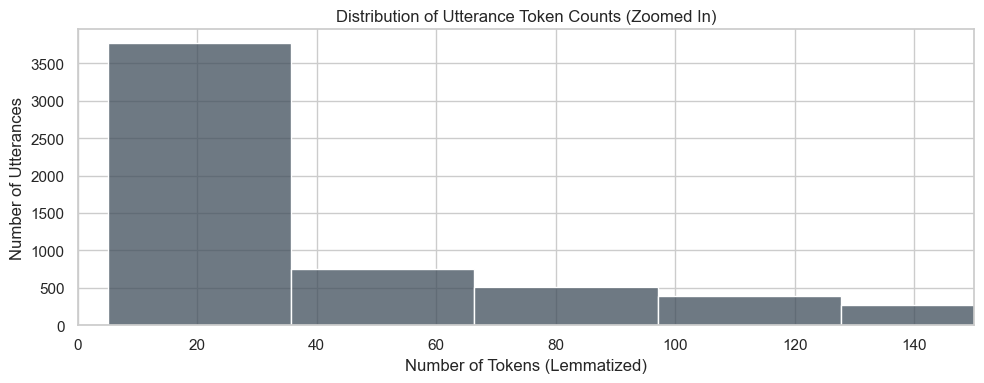

In [57]:
# === TOKEN LENGTH DISTRIBUTION (ZOOMED) ===

plt.figure(figsize=(10, 4))
sns.histplot(debates_initial_df["token_count"], bins=50, kde=False, color=palette["general"]["primary"])
plt.title("Distribution of Utterance Token Counts (Zoomed In)")
plt.xlabel("Number of Tokens (Lemmatized)")
plt.ylabel("Number of Utterances")
plt.xlim(0, 150)
plt.tight_layout()
plt.show()

## 6. Exploratory Data Analysis

In [48]:
# dataframe after all cleaning steps
debates_initial_df.head()

,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id,utterance_id,lemmatized_text,token_count
0,good evening. the television and radio station...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy,1960_1_Presidential_Nixon_Kennedy_001,good evening the television and radio station ...,146
1,"mr. smith, mr. nixon. in the election of 1860,...",Candidate_D,Kennedy,Democrat,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy,1960_1_Presidential_Nixon_Kennedy_002,mr smith mr nixon in the election of 1860 abra...,1290
2,and now the opening statement by vice presiden...,Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy,1960_1_Presidential_Nixon_Kennedy_003,and now the opening statement by vice presiden...,11
3,"mr. smith, senator kennedy. the things that se...",Candidate_R,Nixon,Republican,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy,1960_1_Presidential_Nixon_Kennedy_004,mr smith senator kennedy the thing that senato...,1406
4,"thank you, mr. nixon. that completes the openi...",Moderator,Moderator,NaN,Kennedy,Democrat,1960,presidential,1960_1_Presidential_Nixon_Kennedy,1960_1_Presidential_Nixon_Kennedy_005,thank you mr nixon that complete the opening s...,66


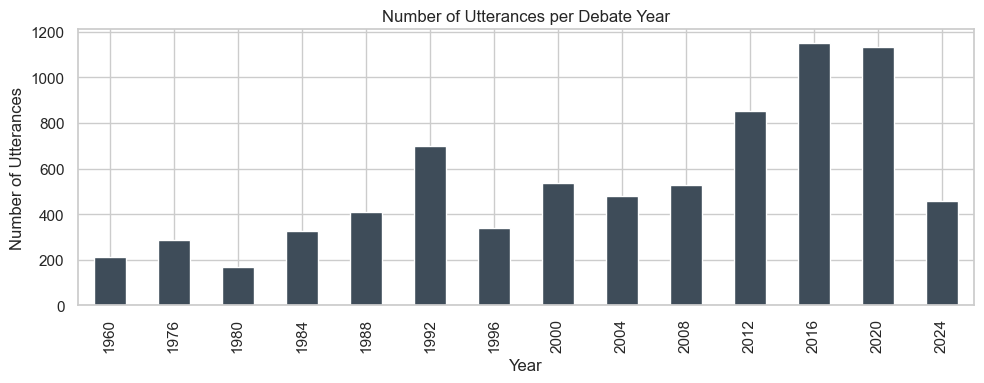

In [58]:
# === UTTERANCES OVER TIME ===

# convert to string if you want cleaner x-axis labels
debates_initial_df["year"] = debates_initial_df["year"].astype(int)

# count utterances per date
utterances_by_year = debates_initial_df["year"].value_counts().sort_index()

# plot
plt.figure(figsize=(10, 4))
utterances_by_year.plot(kind="bar", color=palette["general"]["primary"])
plt.title("Number of Utterances per Debate Year")
plt.xlabel("Year")
plt.ylabel("Number of Utterances")
plt.tight_layout()
plt.show()

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/2765675179.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/2765675179.py:37: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


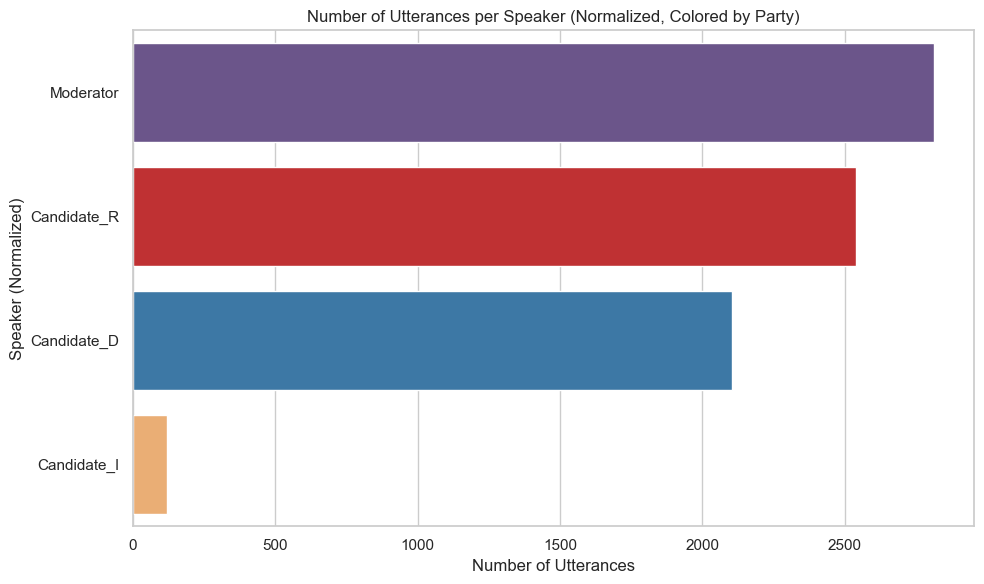

In [68]:
# === UTTERANCES BY SPEAKER (COLORED BY PARTY) ===

# count utterances by speaker_normalized (which includes Candidate_D, Candidate_R, Moderator, etc.)
speaker_counts = debates_initial_df["speaker_normalized"].value_counts().sort_values(ascending=False)

# create dataframe with counts
speaker_df = pd.DataFrame({
    "speaker_normalized": speaker_counts.index,
    "count": speaker_counts.values
})

# extract party for each normalized speaker (one per normalized label)
speaker_party_mapping = (
    debates_initial_df[["speaker_normalized", "party"]]
    .dropna(subset=["party"])  # only keep rows with a known party
    .drop_duplicates(subset=["speaker_normalized"])
    .set_index("speaker_normalized")["party"]
)

# map party info to df, fallback to "Moderator" (neutral)
speaker_df["party"] = speaker_df["speaker_normalized"].map(speaker_party_mapping)
speaker_df["party"] = speaker_df["party"].fillna("Moderator")

# define consistent color palette
party_colors = {
    "Republican": palette["speakers"]["Republican"],
    "Democrat": palette["speakers"]["Democrat"],
    "Independent": palette["speakers"]["Independent"],
    "Moderator": palette["speakers"]["Moderator"],  # fallback for non-candidates
}

# apply color based on party
speaker_df["color"] = speaker_df["party"].map(party_colors)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=speaker_df,
    x="count",
    y="speaker_normalized",
    palette=speaker_df["color"].values
)

plt.title("Number of Utterances per Speaker (Normalized, Colored by Party)")
plt.xlabel("Number of Utterances")
plt.ylabel("Speaker (Normalized)")
plt.tight_layout()
plt.show()

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/734814794.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/734814794.py:39: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


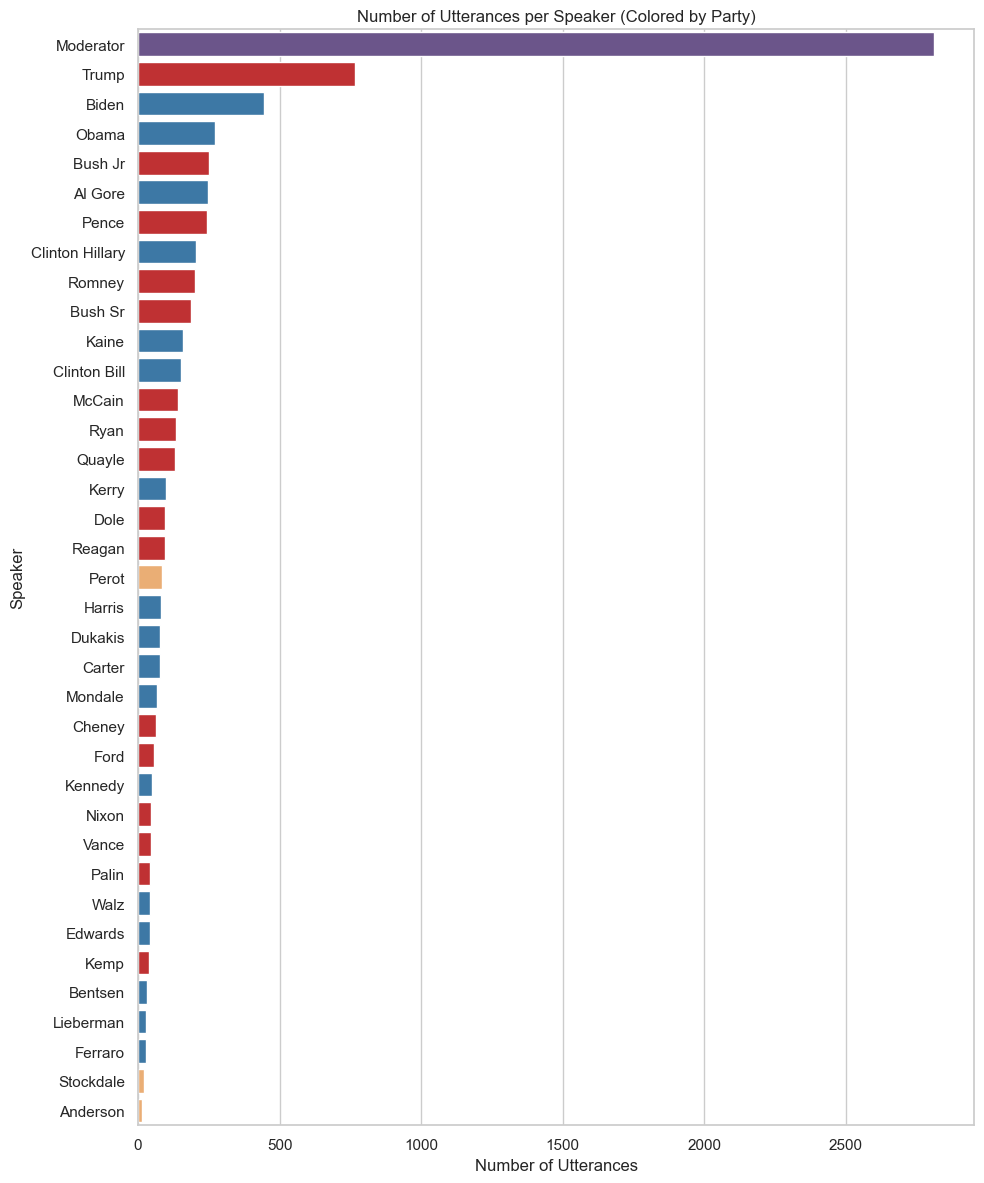

In [70]:
# === UTTERANCES BY SPEAKER (REAL NAMES, COLORED BY PARTY) ===

# count utterances by actual speaker name
speaker_counts = debates_initial_df["speaker"].value_counts().sort_values(ascending=False)

# build dataframe
speaker_df = pd.DataFrame({
    "speaker": speaker_counts.index,
    "count": speaker_counts.values
})

# extract party info per unique speaker
speaker_party_mapping = (
    debates_initial_df[["speaker", "party"]]
    .dropna(subset=["party"])
    .drop_duplicates(subset=["speaker"])
    .set_index("speaker")["party"]
)

# map to speaker_df
speaker_df["party"] = speaker_df["speaker"].map(speaker_party_mapping)

# fill missing with "Moderator" for clarity
speaker_df["party"] = speaker_df["party"].fillna("Moderator")

# define party → color mapping
party_colors = {
    "Republican": palette["speakers"]["Republican"],
    "Democrat": palette["speakers"]["Democrat"],
    "Independent": palette["speakers"]["Independent"],
    "Moderator": palette["speakers"]["Moderator"]
}

# assign colors
speaker_df["color"] = speaker_df["party"].map(party_colors)

# plot
plt.figure(figsize=(10, 12))
sns.barplot(
    data=speaker_df,
    x="count",
    y="speaker",
    palette=speaker_df["color"].values
)

plt.title("Number of Utterances per Speaker (Colored by Party)")
plt.xlabel("Number of Utterances")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/1254930622.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/1254930622.py:42: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


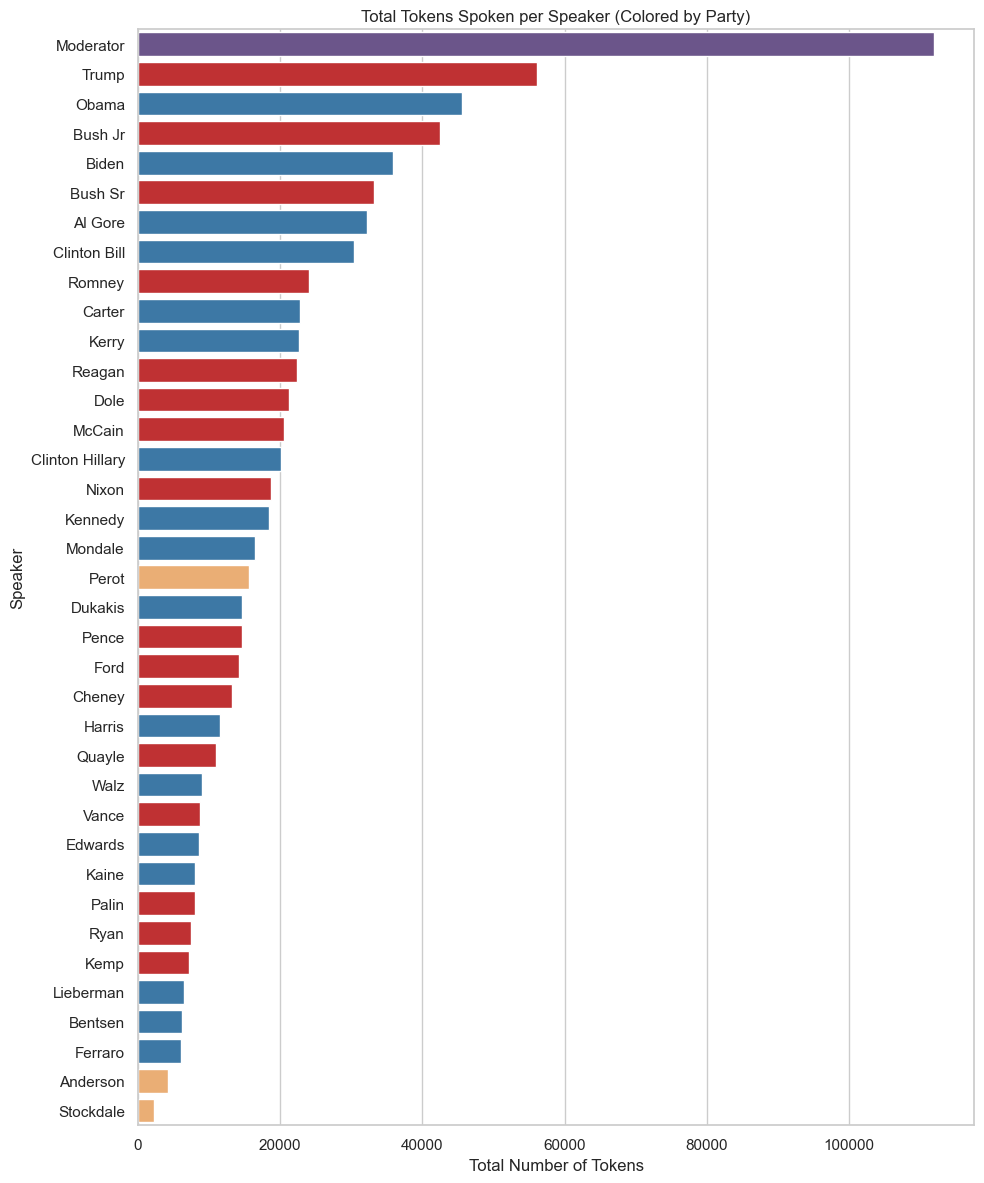

In [72]:
# === TOTAL TOKENS SPOKEN BY SPEAKER (COLORED BY PARTY) ===

# sum total tokens per speaker (use actual speaker names)
tokens_per_speaker = (
    debates_initial_df.groupby("speaker")["token_count"]
    .sum()
    .sort_values(ascending=False)
)

# build dataframe
tokens_df = pd.DataFrame({
    "speaker": tokens_per_speaker.index,
    "total_tokens": tokens_per_speaker.values
})

# get party mapping
speaker_party_mapping = (
    debates_initial_df[["speaker", "party"]]
    .dropna(subset=["party"])
    .drop_duplicates(subset=["speaker"])
    .set_index("speaker")["party"]
)

# map party info to df
tokens_df["party"] = tokens_df["speaker"].map(speaker_party_mapping)

# fill missing with "Moderator" for visual consistency
tokens_df["party"] = tokens_df["party"].fillna("Moderator")

# assign color by party
party_colors = {
    "Republican": palette["speakers"]["Republican"],
    "Democrat": palette["speakers"]["Democrat"],
    "Independent": palette["speakers"]["Independent"],
    "Moderator": palette["speakers"]["Moderator"]
}

tokens_df["color"] = tokens_df["party"].map(party_colors)

# plot
plt.figure(figsize=(10, 12))
sns.barplot(
    data=tokens_df,
    x="total_tokens",
    y="speaker",
    palette=tokens_df["color"].values
)

plt.title("Total Tokens Spoken per Speaker (Colored by Party)")
plt.xlabel("Total Number of Tokens")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

In [76]:
# === LEXICAL RICHNESS (TTR) PER PARTY ===

# group by party
ttr_df = (
    debates_initial_df.groupby("party")["lemmatized_text"]
    .apply(lambda x: " ".join(x).split())  # join utterances, split tokens
    .apply(lambda tokens: pd.Series({
        "total_tokens": len(tokens),
        "unique_tokens": len(set(tokens)),
        "ttr": len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0
    }))
    .reset_index()
)

# sort by TTR
ttr_df = ttr_df.sort_values("ttr", ascending=False)
ttr_df

,party,total_tokens,unique_tokens,ttr
1,Independent,22179.0,2269.0,0.102304
0,Democrat,314742.0,7995.0,0.025402
2,Republican,322755.0,8195.0,0.025391


/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_47775/2958337821.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


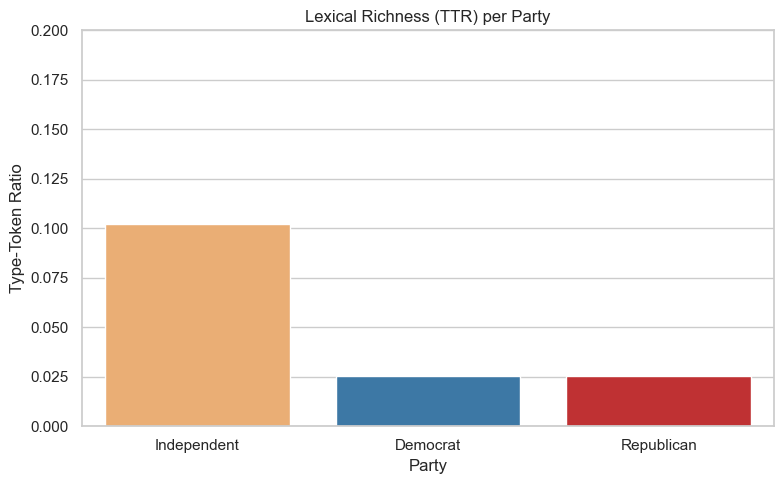

In [79]:
# === TTR (TYPE-TOKEN RATIO) BARPLOT BY PARTY ===

plt.figure(figsize=(8, 5))
sns.barplot(
    data=ttr_df,
    x="party",
    y="ttr",
    palette={
        "Republican": palette["speakers"]["Republican"],
        "Democrat": palette["speakers"]["Democrat"],
        "Moderator": palette["speakers"]["Moderator"],
        "Independent": palette["speakers"]["Independent"],
    }
)

plt.title("Lexical Richness (TTR) per Party")
plt.ylabel("Type-Token Ratio")
plt.xlabel("Party")
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

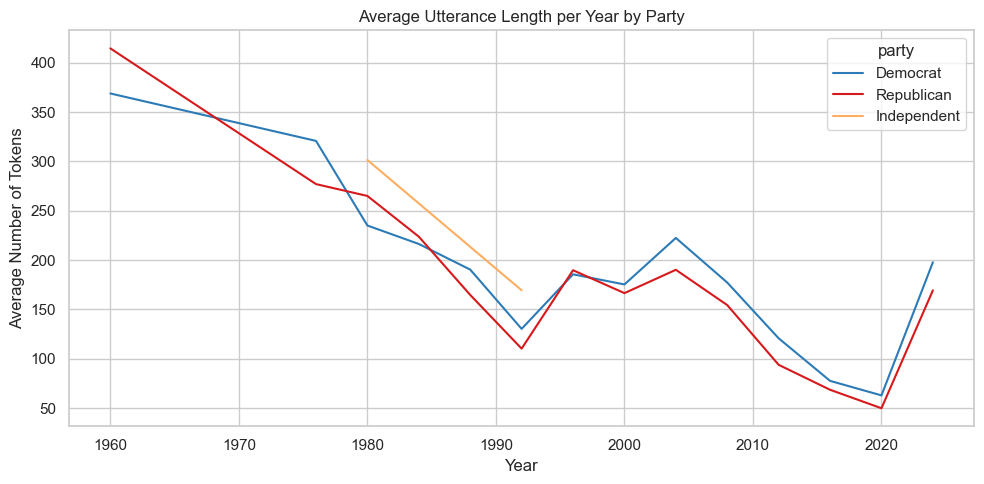

In [83]:
# === AVERAGE UTTERANCE LENGTH PER YEAR BY PARTY ===

# group by year and party, then compute mean token count
avg_length_by_party = (
    debates_initial_df
    .groupby(["year", "party"])["token_count"]
    .mean()
    .reset_index()
)

# fill missing parties (e.g. Moderators) if needed
avg_length_by_party["party"] = avg_length_by_party["party"].fillna("Moderator")

# define the palette based on your JSON structure
party_palette = {
    "Democrat": palette["speakers"]["Democrat"],
    "Republican": palette["speakers"]["Republican"],
    "Independent": palette["speakers"]["Independent"],
    "Moderator": palette["speakers"]["Moderator"]
}

# plot
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=avg_length_by_party,
    x="year",
    y="token_count",
    hue="party",
    palette=party_palette
)

plt.title("Average Utterance Length per Year by Party")
plt.xlabel("Year")
plt.ylabel("Average Number of Tokens")
plt.tight_layout()
plt.show()

## 7. Export Processed Dataset

In [84]:
# === SAVE CLEANED DATAFRAME ===

# define output path
OUTPUT_PATH = DATA_DIR / "debates_dataset.csv"

# save to CSV
debates_initial_df.to_csv(OUTPUT_PATH, index=False)

# 